# Equilibrium in Multiple Dimensions

#### Written for the CBC Quantitative Economics Workshop (September 2022)

#### Author: [John Stachurski](http://johnstachurski.net/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sqrt
from numba import njit
from scipy.optimize import newton, root

In this notebook we expore the problem of computing market equilibrium in a multivariate setting, with many goods.

As a first step, we set up and solve a two-good problem.  Then we shift to higher dimensions.  We will show how gradient-based equation solvers can handle high dimensional problems.

## Two Goods

We first consider a market for two related products, good 0 and good 1, with price vector $p = (p_0, p_1)$.

Supply of good $i$ at price $p$ is 

$$ q^s_i (p) = b_i \sqrt{p_i} $$

Demand of good $i$ at price $p$ is

$$ q^d_i (p) = \exp(-a_{i0} p_0) + \exp(-a_{i1} p_1) + c_i$$

Here $c_i, b_i$ and $a_{ij}$ are parameters.  

For example, the two goods might be computer components that are typically used together, in which case they are complements.  Hence demand depends on the price of both components.

The excess demand functions are

$$ e_i(p) = q^d_i(p) - q^s_i(p), \qquad i = 0, 1 $$

An equilibrium price vector $p^*$ is one where $e_i(p^*) = 0$.  

We set

$$ 
    A = \begin{pmatrix}
            a_{00} & a_{01} \\
            a_{10} & a_{11}
        \end{pmatrix},
            \qquad 
    b = \begin{pmatrix}
            b_0 \\
            b_1
        \end{pmatrix}
    \qquad \text{and} \qquad
    c = \begin{pmatrix}
            c_0 \\
            c_1
        \end{pmatrix}
$$

## Graphical Exploration

Since our problem is only two dimensional, we can use graphical analysis to visualize and help understand the problem.

Our first step is to define the excess demand function

$$ e(p) = 
    \begin{pmatrix}
    e_0(p) \\
    e_1(p)
    \end{pmatrix}
$$

The function below does the job.

In [2]:
def e(p, A, b, c):
    return exp(- A @ p) + c - b * sqrt(p)

Our default parameter values will be

In [3]:
A = ((0.5, 0.4),
     (0.8, 0.2))
A = np.asarray(A)
b = np.ones(2)
c = np.ones(2)

In [4]:
e((1.0, 0.5), A, b, c)

array([0.4965853 , 0.69946288])

Next we plot the two functions $e_0$ and $e_1$ on a grid of $(p_0, p_1)$ values, using contour surfaces and lines.

We will use the following function to build the contour plots.

In [5]:
def plot_excess_demand(ax, good=0, grid_size=100, grid_max=4, surface=True):
    p_grid = np.linspace(0, grid_max, grid_size)
    z = np.empty((100, 100))

    for i, p_1 in enumerate(p_grid):
        for j, p_2 in enumerate(p_grid):
            z[i, j] = e((p_1, p_2), A, b, c)[good]

    if surface:
        cs1 = ax.contourf(p_grid, p_grid, z.T, alpha=0.5)
        plt.colorbar(cs1, ax=ax, format="%.6f")

    ctr1 = ax.contour(p_grid, p_grid, z.T, levels=[0.0])
    plt.clabel(ctr1, inline=1, fontsize=13)


Here's our plot of $e_0$:

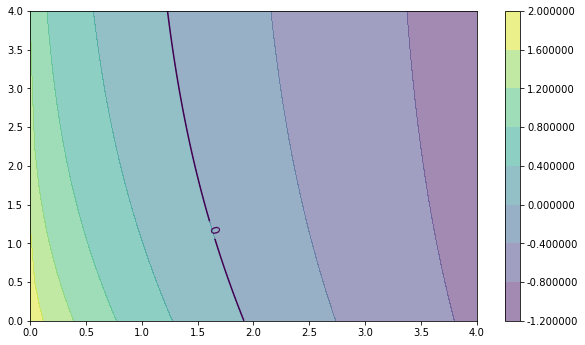

In [6]:
fig, ax = plt.subplots(figsize=(10, 5.7))
plot_excess_demand(ax, good=0)
plt.show()

We see the black contour line of zero, which tells us when $e_0(p)=0$.

For a price vector $p$ such that $e_0(p) = 0$, we know that good $0$ is in equilibrium (demand equals supply).

Here's our plot of $e_1$:

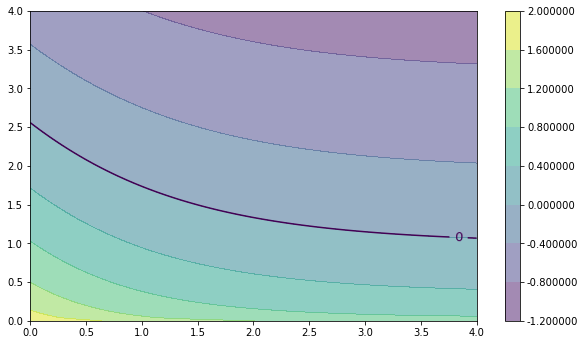

In [7]:
fig, ax = plt.subplots(figsize=(10, 5.7))
plot_excess_demand(ax, good=1)
plt.show()

Now the black contour line of zero tells us when $e_1(p)=0$ (i.e., good $1$ is in equilibrium).

If these two contour lines cross at some vector $p^*$, then $p^*$ is an equilibrium price vector.

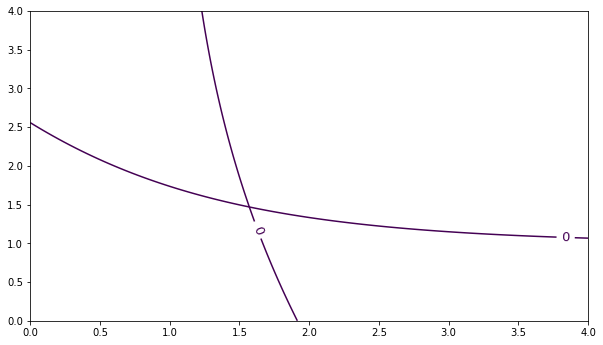

In [8]:
fig, ax = plt.subplots(figsize=(10, 5.7))
for good in (0, 1):
    plot_excess_demand(ax, good=good, surface=False)
plt.show()

It seems there is an equilibrium close to $p = (1.6, 1.5)$.

## Using a Multidimensional Root Finder

To solve for $p^*$ more precisely, we use `root`, a root-finding algorithm from `scipy.optimize`.

We supply $p = (1, 1)$ as our initial guess.

In [9]:
init_p = np.ones(2)

In [10]:
solution = root(lambda p: e(p, A, b, c), init_p, method='hybr')
p = solution.x

Here's the resulting value:

In [11]:
p

array([1.57080182, 1.46928838])

This looks close to our guess from observing the figure.  We can plug it back into $e$ to test that $e(p) \approx 0$:

In [12]:
np.max(np.abs(e(p, A, b, c)))

2.0383694732117874e-13

This is indeed a very small error.

In most cases, for root-finding algorithms applied to smooth functions, supplying the Jacobian of the function leads to better convergence properties.  

In this case we manually calculate the elements of the Jacobian

$$
    J(p) = 
    \begin{pmatrix}
        \frac{\partial e_0}{\partial p_0}(p) & \frac{\partial e_0}{\partial p_1}(p) \\
        \frac{\partial e_1}{\partial p_0}(p) & \frac{\partial e_1}{\partial p_1}(p)
    \end{pmatrix}
$$

and supply the Jacobian as a function, as follows:

In [13]:
@njit
def jacobian(p, A, b, c):
    p_0, p_1 = p
    a_00, a_01 = A[0, :]
    a_10, a_11 = A[1, :]
    j_00 = -a_00 * exp(-a_00 * p_0) - (b[0]/2) * p_0**(-1/2)
    j_01 = -a_01 * exp(-a_01 * p_1)
    j_10 = -a_10 * exp(-a_10 * p_0)
    j_11 = -a_11 * exp(-a_11 * p_1) - (b[1]/2) * p_1**(-1/2)
    J = [[j_00, j_01],
         [j_10, j_11]]
    return np.array(J)

In [14]:
solution = root(lambda p: e(p, A, b, c),
                init_p, 
                jac=lambda p: jacobian(p, A, b, c), 
                method='hybr')
p = solution.x

Now the solution is even more accurate (although, in this low-dimensional problem, the difference is quite small):

In [15]:

np.max(np.abs(e(p, A, b, c)))

1.3322676295501878e-15

## High-Dimensional Problems

Our next step is to investigate a high-dimensional version of the market described above.  This market consists of 5,000 goods.  

The excess demand function is essentially the same, but now the matrix $A$ is $5000 \times 5000$ and the parameter vectors $b$ and $c$ are $5000 \times 1$.

In [16]:
dim = 5000

# Create a random matrix A and normalize the rows to sum to one
A = np.random.rand(dim, dim)
A = np.asarray(A)
s = np.sum(A, axis=0)
A = A / s

# Set up b and c
b = np.ones(dim)
c = np.ones(dim)

Here's the same demand function:

In [17]:
def e(p, A, b, c):
    return exp(- A @ p) + c - b * sqrt(p)

For our particular case, calculating and supplying the Jacobian is not too hard, but you can imagine that it can be very tedious when the functions get more complicated.  

So let's see how we go when the Jacobian is not supplied.

Here's our initial condition

In [18]:
init_p = np.ones(dim)

Now we call `root` again.

**Warning**: The next line of code takes several minutes to run on a standard laptop or desktop.

In [19]:
%%time
solution = root(lambda p: e(p, A, b, c), init_p, method='hybr')

CPU times: user 14min 8s, sys: 1min 43s, total: 15min 52s
Wall time: 5min 25s


In [20]:
p = solution.x

Although it takes a long time to run, the answer is correct up to a high degree of accuracy.

In [21]:
np.max(np.abs(e(p, A, b, c)))

2.377835706113274e-10

## Automatic Differentiation 

To produce a faster and more efficient implementation, we shift to using JAX.

With JAX, we get to big advantages:

1. We can use automatic differentiation to compute the Jacobian, rather than doing it by hand.
2. JAX can parallelize the problem (and send it to the GPU if configured).

In [19]:
!nvidia-smi

Fri Sep 23 06:44:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
| 30%   27C    P8    25W / 320W |   9546MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
import jax
import jax.numpy as jnp

We set up the same demand function, replacing `np` with `jnp`:

In [21]:
@jax.jit
def e(p, A, b, c):
    return jnp.exp(- jnp.dot(A, p)) + c - b * jnp.sqrt(p)

We are going to try to compute the equilibrium price using the multivariate version of Newton's method, which means iterating on the equation

$$ p_{n+1} = p_n - J(p_n)^{-1} e(p_n) $$

starting from some initial guess of the price vector $p_0$.  (Here $J$ is the Jacobian of $e$.) 

In [32]:
def newton(f, x_0, tol=1e-5):
    f_prime = jax.grad(f)
    def q(x):
        return x - jnp.linalg.solve(jax.jacobian(f)(x), f(x))

    error = tol + 1
    x = x_0
    while error > tol:
        y = q(x)
        error = jnp.linalg.norm(x - y)
        x = y
        
    return x

Let's see whether this can solve the problem and how long it takes

In [33]:
%%time
p = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()

CPU times: user 808 ms, sys: 413 ms, total: 1.22 s
Wall time: 1.18 s


In [34]:
%%time
p = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()

CPU times: user 835 ms, sys: 363 ms, total: 1.2 s
Wall time: 1.17 s


In [35]:
np.max(np.abs(e(p, A, b, c)))

1.1920929e-07

We still have a solution that's very accurate and the compute time is massively reduced (assuming JAX is connecting to a GPU).